<a href="https://colab.research.google.com/github/mnawfal29/Delta_Sysad_Tasks/blob/main/ChessFEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chess FEN Predictor

#### What Is FEN?

FEN is the abbreviation of Forsyth-Edwards Notation, and it is the standard notation to describe positions of a chess game. Steven J. Edwards, a computer programmer, created this notation system based on another system designed by the journalist David Forsyth. Edwards modified the older notation system so that chess software could use it.
FEN differs from the Portable Game Notation (PGN) because it denotes only a single position instead of the moves that lead to it.

#### Why Is FEN Important?

FEN is important because it makes it easy to translate any chess position into a single line of text. It facilitates the process of recreating positions using computers and allows players to share them and restart games from any point they desire.

For this reason, FEN is especially helpful to chess teachers, coaches, trainers, and students. It replaces the need for chess mentors to send large PGN files to their students and speeds up the process of sharing positions, even when people are far apart.

### Import modules

In [ ]:
import os
import glob
import zipfile
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as pltimg

### Intialize colab environment

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! touch ./kaggle.json
! echo '# Enter kaggle api here' >> ./kaggle.json
! cp ./kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download "koryakinp/chess-positions" #Download the dataset
! pwd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 4.00G/4.01G [00:29<00:00, 228MB/s]
100% 4.01G/4.01G [00:29<00:00, 145MB/s]
/content


Extract files from .zip file

In [ ]:
with zipfile.ZipFile("/content/chess-positions.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [ ]:
train = glob.glob("./dataset/train/*.jpeg")
test = glob.glob("./dataset/test/*.jpeg")
len(train), len(test)

(80000, 20000)

In [ ]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
device

device(type='cuda', index=0)

### Functions

In [ ]:
def fen_from_path(path):
    """Return the fen from path of image"""
    return os.path.splitext(os.path.basename(path))[0]

In [ ]:
def image_extract(path):
    """Return tensor of shape (3 x height_board x width_board) and fen from path"""
    image = pltimg.imread(path)
    final_img = torch.tensor(image).permute(2, 0, 1)
    return final_img, fen_from_path(path)

In [ ]:
def fen_to_piece_code(fen):
    """
    Return fen from tensor of piece code
    Total 13 codes
    """
    chess_pieces = ' pnbrqkPNBRQK'
    code = []
    for i in ''.join(fen.split('-')):
        if i.isdigit():
            code.extend([0] * int(i))
        elif i.isalpha():
            code.append(chess_pieces.index(i))
    return torch.tensor(code, device = device)

In [ ]:
def piece_code_to_fen(code):
    """
    Return tensor of piece code from fen
    """
    chess_pieces = ' pnbrqkPNBRQK'
    s = ''
    count = 0
    for i in range(len(code)):
        if i%8 == 0 and i != 0:
            if count != 0:
                s = s + str(count)
                count = 0
            s = s + '-'
        if code[i] == 0:
            count += 1
        else:
            if count != 0:
                s = s + str(count)
                count = 0
            s = s + chess_pieces[code[i]]
    if count != 0:
        s = s + str(count)
    return s

In [ ]:
def board_splitter(board_path):
    """
    Returns
    (i) Tensor of shape (64 x 3 x height_square x width_square) containing images of all squares in chess board
    (ii) Code for chess pieces
    """
    board, fen = image_extract(board_path)
    code = fen_to_piece_code(fen)
    height, width = board.shape[-2:]
    height_square, width_square = height // 8, width // 8
    final_img = torch.stack([board[i].reshape(8, height_square, 8, width_square).swapaxes(1, 2).reshape(64, height_square, width_square) for i in range(3)], dim = 0)

    return final_img.permute(1, 0, 2, 3).to(device), code

In [ ]:
def get_num_correct(preds, labels):
    return (preds.argmax(axis = 1) == labels).sum().item()

### Display sample images from the training dataset

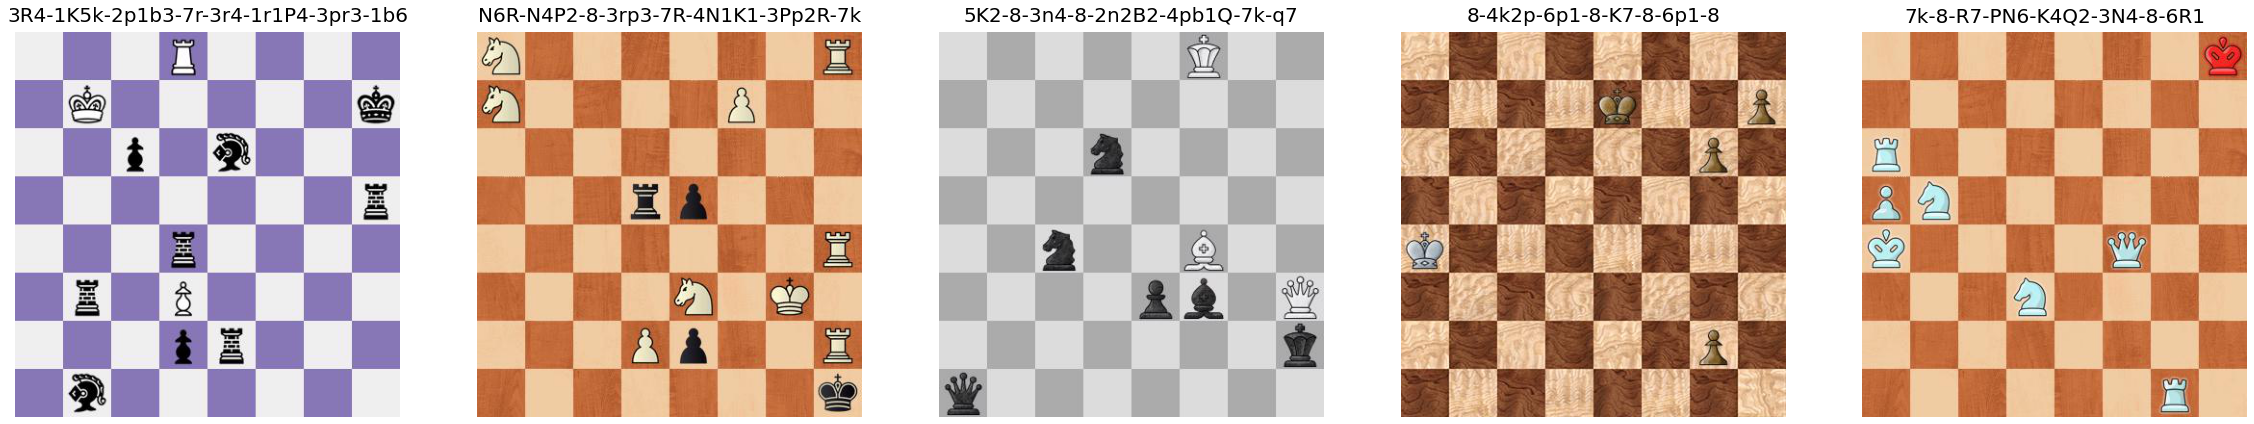

In [ ]:
f, axarr = plt.subplots(1,5, figsize=(40, 50))
path_list = random.sample(train, 5)

for i in range(5):
    axarr[i].set_title(fen_from_path(path_list[i]), fontsize=20, pad=10)
    axarr[i].imshow(pltimg.imread(path_list[i]))
    axarr[i].axis('off')

### Implementing CNN model

In [ ]:
class Network(nn.Module):
    """
    Implements an CNN to detect the individual pieces of a chess board
    It implements 2 Convolutional layers and 3 Linear layers
    """
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 5)

        self.fc1 = nn.Linear(in_features=12 * 10 * 10, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=13)

    def forward(self, t):
        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = t.reshape(-1, 12 * 10 * 10)

        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)

        return F.softplus(t)

### Training the model

In [ ]:
network = Network().to(device)

optimizer = optim.Adam(network.parameters(), lr=0.0001)

batch_size = 64
total_correct = 0
total_loss = 0
total_correct_list = []
total_loss_list = []

for epoch in range(3):
    path_list = train

    for path in path_list:
        images, labels = board_splitter(path)
        preds = network(images.float())
        loss = F.cross_entropy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_correct += get_num_correct(preds, labels)
        total_loss += loss.item()
        total_correct_list.append(total_correct)
        total_loss_list.append(total_loss)
    print(
        "epoch:", epoch,
        f"total_loss:{total_loss : .3f}",
        "total_correct:", total_correct,
        f"percentage_accuracy:{total_correct / (64 * len(path_list)) * 100 : .3f}%"
    )
    total_correct = 0
    total_loss = 0

epoch: 0 total_loss: 2098.522 total_correct: 5072274 percentage_accuracy: 99.068%
epoch: 1 total_loss: 1529.139 total_correct: 5083532 percentage_accuracy: 99.288%
epoch: 2 total_loss: 1529.865 total_correct: 5083919 percentage_accuracy: 99.295%


### Testing the model

In [ ]:
path_list = test
total_correct = 0

for path in path_list:
        images, labels = board_splitter(path)
        preds = network(images.float())
        total_correct += get_num_correct(preds, labels)
print("Final accuracy: ", total_correct / (64 * len(path_list)) * 100, "%", sep = "")

Final accuracy: 99.31351562500001%


### Displaying FEN for testing data

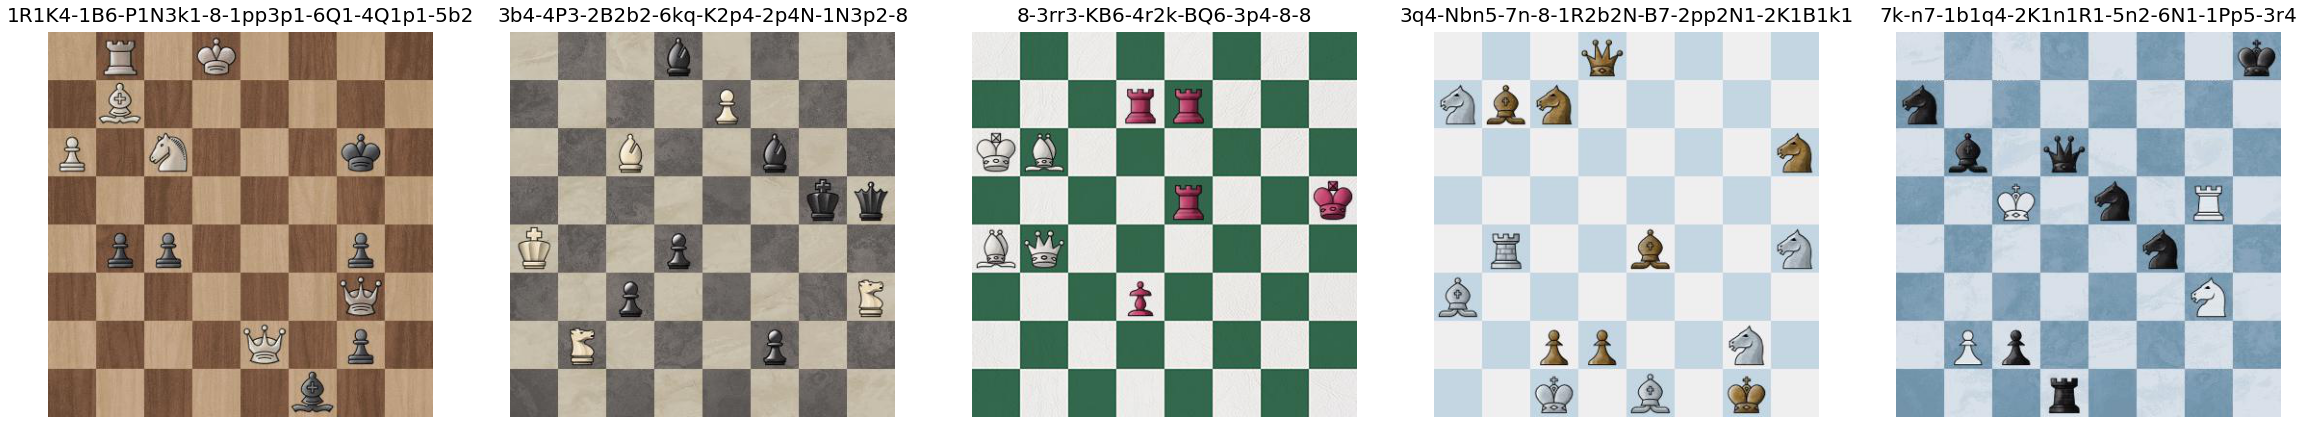

In [ ]:
f, axarr = plt.subplots(1,5, figsize=(40, 50))
path_list = random.sample(test, 5)

for i in range(5):
    axarr[i].set_title(fen_from_path(path_list[i]), fontsize=20, pad=10)
    axarr[i].imshow(pltimg.imread(path_list[i]))
    axarr[i].axis('off')

### Saving model state

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(network.state_dict(), "/content/drive/MyDrive/ChessFEN")

In [ ]:
! ls

chess-positions.zip  dataset  drive  kaggle.json  sample_data  test  train


In [ ]:
! rm kaggle.json